## Final Project

#### Problem statement

Millions of transactions payments to sellers are made everyday on ecommerce platform like shopee or lazada. With the increase in volume of transactions: buyers to sellers, an intelligent system of fraud detection is required for the e-commerce to prevent giving frauster money.

Questions: 
Q1: how to  predict if a tranction is a fraud,using a selected list of given attributed
Q2: is the classification model better than the current Flagging system that flagged transactions that are more than 200,000?

Target Columns: 'isFraud'

Objective:
Build a Classification Model that can predict if a transaction is fraud or not fraud
    - model 1: Logistic Regression
    - model 2: KNN
    - model 3: Random Forest
    
Determine if the Classification model is more accurate compared to the baseline:


#### Data Source

https://www.kaggle.com/ntnu-testimon/paysim1

#### Risks or limitations
- Curse of dimentionality:
The dataset might be too thin 6m rows and
- imbalance dataset, the non-fraud observations might be over presented
- unknown variables that are not given in the orginal dataset that might have predicting power over whether a transaction is fraud

### Description of Given Dataset

1. step: Maps a unit of time in the real world. In this case 1 step is 1 hour of time.
2. type: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
3. amount: amount of the transaction in local currency
4. nameOrig: customer who started the transaction
5. oldbalanceOrg: initial balance before the transaction
6. newbalanceOrig: customer's balance after the transaction.
7. nameDest: recipient ID of the transaction. 
8. oldbalanceDest: initial recipient balance before the transaction.
9. newbalanceDest: recipient's balance after the transaction.
10. isFraud: identifies a fraudulent transaction (1) and non fraudulent (0)
11. ifFlaggedFraud: flags illegal attempts to transfer more than 200.000 in a single transaction. 

> 1. LOADING DATASET

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path_to_file = 'C:\\Users\\harriet.ly\\Documents\\GitHub\\GA_projectsV2\\Project4\\fraud.csv'
dataset = pd.read_csv(path_to_file)
dataset.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


In [3]:
# check number of rows and columns
dataset.shape

(6362620, 11)

In [4]:
# Test if there is any null values
dataset.isnull().values.any()

False

In [5]:
# Target Col is "isFraud"
# Check imbalance. Data is imbalanced.
dataset.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [34]:
dataset.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [61]:
# The current flag system identified only 16 cases out of 8231 real fraud cases, which is very low
Current_sensitivity = 16 / 8231
Current_sensitivity

0.0019438707325962824

In [6]:
# Randomly sampled 200K out of 6m+ of the original data, to decrease the size of data for smote tomek to run faster later

from random import sample

data_sample_index =  np.array(sample(range(len(dataset)), 200000))
data = dataset.iloc[data_sample_index]
data.shape

(200000, 11)

In [7]:
# imbalance in a smaller sample
data.isFraud.value_counts()

0    199718
1       282
Name: isFraud, dtype: int64

In [8]:
# drop 'Step', 'nameOrig' and 'nameDest' as it is considered as unique as ID and will not have predictive power
data = data[['type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFlaggedFraud','isFraud']]
data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud
3787095,CASH_OUT,174171.70,0.0,0.00,271168.98,445340.67,0,0
2720353,CASH_IN,48085.58,50203.0,98288.58,0.00,181812.81,0,0
2106126,CASH_OUT,137918.45,0.0,0.00,2438185.12,2576103.56,0,0
3471772,TRANSFER,9799.16,0.0,0.00,389962.24,399761.40,0,0
5808348,PAYMENT,8921.62,0.0,0.00,0.00,0.00,0,0


> 2. EDA

We will going one by one non target col to select as feature, and also engineer some new features

In [32]:
# 1. First, Check if col "isFlaggedFraud" is completed co-related to "amount". If amount > 200k, isFlaggedFraud =1
data_flaggedFraud = data[data['isFlaggedFraud']==1]
data_flaggedFraud[data_flaggedFraud['amount']<200000].shape 

KeyError: 'isFlaggedFraud'

In [10]:
# All of rows are flagged Fraud has amount >200K
# Drop "isFlaggedFraud", as its information is already captured in "amount"
data = data[['type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']]
data.head(3)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
3787095,CASH_OUT,174171.70,0.0,0.00,271168.98,445340.67,0
2720353,CASH_IN,48085.58,50203.0,98288.58,0.00,181812.81,0
2106126,CASH_OUT,137918.45,0.0,0.00,2438185.12,2576103.56,0


In [11]:
# 2. Next, we check if the Col "amount" is equal to the abs(newbalanceOrig-oldbalanceOrg)
# In a genuine transaction, the absolute difference between the
# beginning and ending balance of the original account should equal to the amount of transactions.

data['error_Orig']= abs(data['oldbalanceOrg'] - data['newbalanceOrig']) - data['amount'] # create error column
data[data['error_Orig']>0].shape # count how many transaction got error

(28678, 8)

In [12]:
# there are 28k+ transactions whose "newbalanceOrig" do not tally with the 'amount' and 'oldbalanceOrg', hence 
# we will include  'error_Orig' as an attribute in our fraud detection model

In [13]:
#3. Likewise, we check for error in Dest
data['error_Dest']= abs(dataset['newbalanceDest']-dataset['oldbalanceDest'])-dataset['amount']
data[data['error_Dest']>0].shape

(49279, 9)

In [14]:
# there are 49k+ transactions whose "newbalanceDest" do not tally with the 'amount' and 'oldbalanceDest', hence 
# 'error_Dest' should be used as an attribute in our fraud detection model

In [15]:
# although we now need to be extra careful of multicollinearity in our model as correlated attributes might be present

In [16]:
# 4. Drop "newbalanceOrig" because it can be calculated from "amount", 'oldbalanceOrg' and "error_Orig"
# Drop "newbalanceDest" too

data = data[['type','amount','oldbalanceOrg','error_Orig','oldbalanceDest','error_Dest','isFraud']]
data.head(3)

,type,amount,oldbalanceOrg,error_Orig,oldbalanceDest,error_Dest,isFraud
3787095,CASH_OUT,174171.70,0.0,-174171.70,271168.98,-0.01,0
2720353,CASH_IN,48085.58,50203.0,0.00,0.00,133727.23,0
2106126,CASH_OUT,137918.45,0.0,-137918.45,2438185.12,-0.01,0


In [17]:
#5. Check on the categorical attribute 'type'
data['type'].unique()

array(['CASH_OUT', 'CASH_IN', 'TRANSFER', 'PAYMENT', 'DEBIT'],
      dtype=object)

In [18]:
#to use get_dummies to transform this categorical col into 5 Cols that take values 0 and 1
data=pd.get_dummies(data=data, columns=['type'])

In [29]:
#rearrange col
data=data[['amount','oldbalanceOrg','error_Orig','oldbalanceDest','error_Dest','type_CASH_IN','type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER','isFraud']]
data.head(3)

,amount,oldbalanceOrg,error_Orig,oldbalanceDest,error_Dest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
3787095,174171.70,0.0,-174171.70,271168.98,-0.01,0,1,0,0,0,0
2720353,48085.58,50203.0,0.00,0.00,133727.23,1,0,0,0,0,0
2106126,137918.45,0.0,-137918.45,2438185.12,-0.01,0,1,0,0,0,0


> FEATURE SELECTION

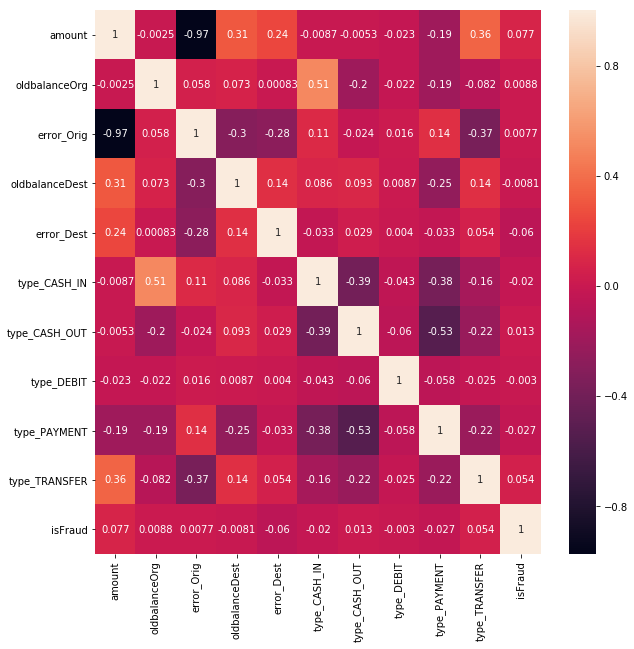

In [27]:
# Correlation examiniation via Heatmap
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)

In [30]:
#Drop 'error_Orig' as it is highly correleated to 'amount'
data=data[['amount','oldbalanceOrg','oldbalanceDest','error_Dest','type_CASH_IN','type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER','isFraud']]
data.head(3)

,amount,oldbalanceOrg,oldbalanceDest,error_Dest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
3787095,174171.70,0.0,271168.98,-0.01,0,1,0,0,0,0
2720353,48085.58,50203.0,0.00,133727.23,1,0,0,0,0,0
2106126,137918.45,0.0,2438185.12,-0.01,0,1,0,0,0,0


In [62]:
#Select Xs and y
feature_cols=['amount','oldbalanceOrg','oldbalanceDest','error_Dest','type_CASH_IN','type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER']
X = data[feature_cols]
y = data['isFraud']

In [63]:
# Rebalance using Smote Tomek
from imblearn.combine import SMOTETomek
#instantiate
sm = SMOTETomek()
X_resampled, y_resampled = sm.fit_sample(X, y)

In [64]:
# Checking for balance
y_resampled.sum() # number of Fraud case is 200K

199607

In [65]:
y_resampled.shape # number of nonFraud case is also around ~200K. Data is balanced

(399214,)

In [66]:
# Standard Scaling all Features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # instantiate
scaled_Xs = scaler.fit_transform(X_resampled)

In [67]:
X = pd.DataFrame(scaled_Xs, columns=feature_cols)
X.head(3)

,amount,oldbalanceOrg,oldbalanceDest,error_Dest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-0.339430,-0.421708,-0.190339,0.235110,-0.350528,1.150642,-0.05718,-0.452946,-0.634133
1,-0.406874,-0.403263,-0.303323,0.332758,2.852837,-0.878446,-0.05718,-0.452946,-0.634133
2,-0.358822,-0.421708,0.712567,0.235110,-0.350528,1.150642,-0.05718,-0.452946,-0.634133


In [68]:
# Target variable
y = y_resampled

In [69]:
# Split to training and test datasets to 75% training, 25 % test (default)
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=123)

>Model 1: Logistic Regression

In [70]:
# Fit a logistic Regression model on the training set
from sklearn.linear_model import LogisticRegression

logreg= LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [71]:
# Examine the coeffcient
print(logreg.coef_)
print(feature_cols)

[[-10.85128093  28.07728759  -0.47306425  -9.46939898 -78.51129815
   25.5681061    1.64991604   2.99025424  23.85704819]]
['amount', 'oldbalanceOrg', 'oldbalanceDest', 'error_Dest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


**Interpretation**:
- The higher the amount, the more likely the transaction is fraud
- The higher of the beginning balance of Origin or Destination Accounts, the less likely the transaction is fraud
- Cash_in type has the least likelihood of fraud, compared to the other four types

In [72]:
#Make predictions on testing set
y_pred1 = logreg.predict(X_test) 

In [73]:
# Validation of the model performance on the testing set

In [74]:
# Define a function to draw ROC curve
def get_ROC_curve(y_pred):
    # find the area under the curve.
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot of a ROC curve.
    plt.figure(figsize=[4,4])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for Model', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    print ('Auc:',roc_auc)

 Accuracy Score: 0.9423570197587271 

--------------------Confusion Matrix-------------------- 

[[46567  3316]
 [ 2437 47484]] 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.95      0.93      0.94     49883
          1       0.93      0.95      0.94     49921

avg / total       0.94      0.94      0.94     99804
 

--------------------ROC Curve-------------------- 

 ROC Score: 0.9423536580696885 



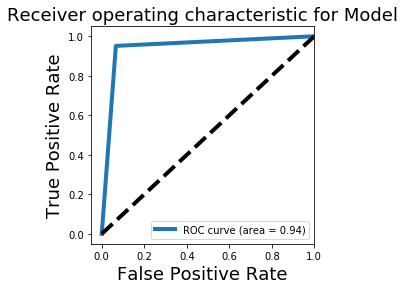

Auc: 0.9423536580696885
--------------------Sensitivity and Specificity-------------------- 

 Sensitivity Score: 0.951182868932914 

 Specificity Score: 0.9335244472064631 



In [75]:
# Define a function to benchmark Model Performance
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

def get_model_performance(y_pred):
    print (' Accuracy Score: {}' .format(metrics.accuracy_score(y_test,y_pred)), '\n')

    print (('-'* 20 + 'Confusion Matrix' + '-'*20), '\n')
    confusion = metrics.confusion_matrix(y_test, y_pred)
    print(confusion,'\n')

    print (('-'* 20 + 'Classification Report' + '-'*20), '\n')
    print ('Classification report: \n', classification_report(y_test, y_pred), '\n')

    print (('-'* 20 + 'ROC Curve' + '-'*20), '\n')
    print (' ROC Score: {}' .format(metrics.roc_auc_score(y_test,y_pred)), '\n')
    get_ROC_curve(y_pred)

    print (('-'* 20 + 'Sensitivity and Specificity' + '-'*20), '\n')
    #True positive = predicted Fraud and is Fraud
    TP = confusion[1][1]
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]

    # calculate the sensitivity: aim to make sensitivity as high as possible
    print(' Sensitivity Score: {}' .format(TP / float(TP + FN)), '\n')
    # calculate the specificity
    print(' Specificity Score: {}' .format(TN / float(TN + FP)), '\n')
    
get_model_performance(y_pred1)

- We set a lower probability threshold (lower than the default 0.5), to predict more positive classes. This means we will predict more true positives, but fewer true negatives.
- The reason for this is that we have imbalanced penality for misclassification. A false negative (real fraud but predicted as non-fraud) is much more costly than a false positive (non-fraud but predicted as fraud). In the former, the bank can risk losing millions, while in the latter, only a few customers are annoyed.
- Increase sensitivity by lowering the threshold for predicting Fraud, from 0.5 to 0.3

 Accuracy Score: 0.9010260109815238 

--------------------Confusion Matrix-------------------- 

[[40195  9688]
 [  190 49731]] 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       1.00      0.81      0.89     49883
          1       0.84      1.00      0.91     49921

avg / total       0.92      0.90      0.90     99804
 

--------------------ROC Curve-------------------- 

 ROC Score: 0.9009897623289803 



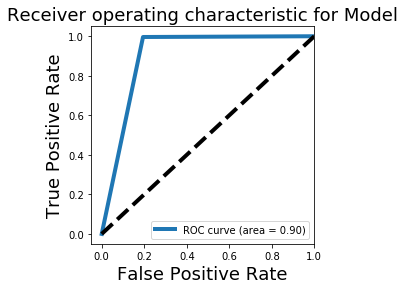

Auc: 0.9009897623289803
--------------------Sensitivity and Specificity-------------------- 

 Sensitivity Score: 0.9961939864986679 

 Specificity Score: 0.8057855381592928 



In [76]:
y_pred_prob = logreg.predict_proba(X_test)[:,1] # Get probability prediction
y_pred2=y_pred_prob > 0.3 
get_model_performance(y_pred2)

In [77]:
# Sensitity Score has increased to near 99.9% after lowering threshold of prob to detect Fraud to 0.3

> Model 2: KNN

In [78]:
from sklearn.neighbors import KNeighborsClassifier

In [79]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [80]:
y_pred3 = knn.predict(X_test)

 Accuracy Score: 0.9969540298986013 

--------------------Confusion Matrix-------------------- 

[[49643   240]
 [   64 49857]] 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     49883
          1       1.00      1.00      1.00     49921

avg / total       1.00      1.00      1.00     99804
 

--------------------ROC Curve-------------------- 

 ROC Score: 0.9969533580275126 



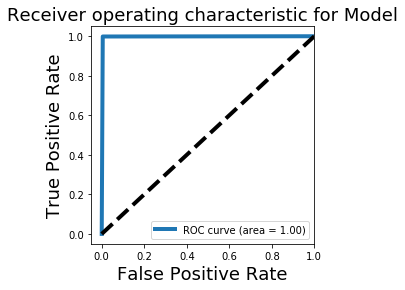

Auc: 0.9969533580275126
--------------------Sensitivity and Specificity-------------------- 

 Sensitivity Score: 0.9987179743995513 

 Specificity Score: 0.9951887416554738 



In [81]:
get_model_performance(y_pred3)

In [82]:
# KNN performs better than Logistic regression model

> Model 3: RandomForest Classifier Model

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
rfc = RandomForestClassifier(random_state = 42)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [85]:
y_pred4= rfc.predict(X_test)

amount = 0.17244364815454233
oldbalanceOrg = 0.3284089619590472
oldbalanceDest = 0.07142427535485914
error_Dest = 0.06915524853856683
type_CASH_IN = 0.1152126092492531
type_CASH_OUT = 0.05789847170064072
type_DEBIT = 0.0014117698240237622
type_PAYMENT = 0.07801696838893213
type_TRANSFER = 0.10602804683013486
Feature ranking:
1. feature 1 (0.328409)
2. feature 0 (0.172444)
3. feature 4 (0.115213)
4. feature 8 (0.106028)
5. feature 7 (0.078017)
6. feature 2 (0.071424)
7. feature 3 (0.069155)
8. feature 5 (0.057898)
9. feature 6 (0.001412)


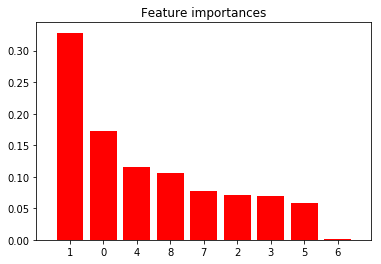

In [94]:
importances = rfc.feature_importances_
for name, importance in zip(feature_cols, importances):
    print(name, "=", importance)

indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

The rank of feature importance shows that `oldbalanceOrg` is the one with the strongest predictive power.

 Accuracy Score: 0.9982666025409803 

--------------------Confusion Matrix-------------------- 

[[49732   151]
 [   22 49899]] 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     49883
          1       1.00      1.00      1.00     49921

avg / total       1.00      1.00      1.00     99804
 

--------------------ROC Curve-------------------- 

 ROC Score: 0.998266110162374 



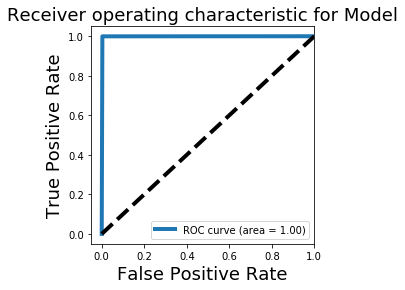

Auc: 0.998266110162374
--------------------Sensitivity and Specificity-------------------- 

 Sensitivity Score: 0.9995593036998458 

 Specificity Score: 0.9969729166249023 



In [88]:
get_model_performance(y_pred4)

**Conclusion**

Logistic Regression, KNN and RandomForest models all give high accuracy on the testing set, with sensitivity >95%.
However, Logistic Regression will be more useful can its coef can be interpreted.
Sensitivy Score of 99.9% is much better than the baseline (which only transaction >200K is flagged Fraud)
More Features should be gather to build a stronger model, like Country of Origin and Destination, or timestamp of the transactions.